### Jupyter Notebook to compute morphological metrics from axon and myelin segmentation of a microscopy sample.

- To use it, you need the paths of the microscopy image and the segmentation prediction (output of AxonDeepSeg).


#### Imports

In [149]:
import numpy as np
from skimage import io
from scipy.misc import imread, imsave
import os
import imageio
import json
from skimage import transform
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from shutil import copy
import math
from AxonDeepSeg.apply_model import axon_segmentation
from AxonDeepSeg.testing.segmentation_scoring import *
from scipy.misc import imread, imsave
from skimage import measure
from skimage.measure import regionprops
%matplotlib inline

#### Read image and segmented prediction

In [150]:
# Change the image and segmentation paths here for your sample:
path_img = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/image.png'
path_pred = '/Users/rudinakaprata/Documents/Aldo/axondeepseg/AxonDeepSeg/data_test/AxonDeepSeg.png'

In [151]:
# Read paths and compute axon/myelin masks
img = imageio.imread(path_img)
pred = imageio.imread(path_pred)
pred_axon = pred > 200
pred_myelin = np.logical_and(pred >= 50, pred <= 200)
path_folder, file_name = os.path.split(path_img)

#### Function definitions

In [152]:
def get_pixelsize(path_pixelsize_file):

    text_file = open(path_pixelsize_file, "r")
    pixelsize = float(text_file.read())
    text_file.close()
    return pixelsize

In [153]:
def get_axon_morphometrics(pred_axon):
    
    # Array for keeping axon-wise metrics
    stats_array = np.empty(0)

    # Label each axon object
    labels = measure.label(pred_axon)
    axon_objects = regionprops(labels)

    # Get axon morphometrics of interest
    for props in axon_objects:
    
        # Centroid
        y0, x0 = props.centroid
        # Solidity
        solidity = props.solidity
        # Eccentricity
        eccentricity = props.eccentricity
        # Axon equivalent diameter in micrometers
        axon_diam = (props.equivalent_diameter)*get_pixelsize(os.path.join(path_folder,'pixel_size_in_micrometer.txt'))
        # Axon orientation angle
        orientation = props.orientation
    
        # Add metrics to list of dictionaries
        stats = {'y0': y0, 'x0': x0, 'axon_diam': axon_diam, 'solidity':solidity,'eccentricity': eccentricity,
                 'orientation':orientation}
        stats_array = np.append(stats_array, [stats], axis=0)
        
    return stats_array

In [154]:
def save_axon_morphometrics(path_folder,stats_array):

    np.save(os.path.join(path_folder,'axonlist.npy'),stats_array)

In [155]:
def load_axon_morphometrics(path_folder):

    stats_array = np.load(os.path.join(path_folder,'axonlist.npy'))
    return stats_array

In [171]:
def get_aggregate_morphometrics(pred_axon, pred_myelin):
    
    # Compute AVF (axon volume fraction) = area occupied by axons in sample
    avf = np.count_nonzero(pred_axon)/float((pred_axon.size))
    # Compute MVF (myelin volume fraction) = area occupied by myelin sheaths in sample
    mvf = np.count_nonzero(pred_myelin)/float((pred_myelin.size))
    
    # Estimate aggregate g-ratio = sqrt(1/(1+MVF/AVF))
    gratio = math.sqrt(1/(1+(float(mvf)/float(avf))))
    
    # Get individual axons metrics and compute mean axon diameter
    stats_array = get_axon_morphometrics(pred_axon)
    axon_diam_list = [d['axon_diam'] for d in stats_array]
    mean_axon_diam = np.mean(axon_diam_list)
    
    # Estimate mean myelin diameter (axon+myelin diameter) by using aggregate g-ratio = mean_axon_diam/mean_myelin_diam
    mean_myelin_diam = mean_axon_diam/gratio
    
    # Estimate mean myelin thickness = mean_myelin_radius - mean_axon_radius
    mean_myelin_thickness = (float(mean_myelin_diam)/2) - (float(mean_axon_diam)/2)
    
    # Compute axon density (number of axons per mm2)
    y, x = pred_axon.shape
    img_area_mm2 = float(pred_axon.size)*get_pixelsize(os.path.join(path_folder,'pixel_size_in_micrometer.txt'))*get_pixelsize(os.path.join(path_folder,'pixel_size_in_micrometer.txt'))/(float(1000000))
    axon_density_mm2 = float(len(axon_diam_list))/float(img_area_mm2)
    
    # Create disctionary to store aggregate metrics
    aggregate_metrics = {'avf': avf, 'mvf': mvf, 'gratio': gratio, 'mean_axon_diam': mean_axon_diam,
                         'mean_myelin_diam': mean_myelin_diam,'mean_myelin_thickness': mean_myelin_thickness,
                         'axon_density_mm2': axon_density_mm2}

    return aggregate_metrics

In [157]:
def write_aggregate_morphometrics(path_folder,aggregate_metrics):
    
    f = open(os.path.join(path_folder,'aggregate_morphometrics.txt'), 'w')
    f.write('aggregate_metrics: ' + repr(aggregate_metrics) + '\n')
    f.close()

### Step-by-step use case: extract morphometrics from a segmented microscopy sample

#### 1) Get axon morphometrics

In [164]:
# Compute axon morphometrics
stats_array = get_axon_morphometrics(pred_axon)

#### 2) Save axon morphometrics and load back

In [165]:
save_axon_morphometrics(path_folder,stats_array)
stats_array = load_axon_morphometrics(path_folder)

#### 3) Extract and plot axon diameter distribution

In [166]:
# Get axon diameter distribution
axon_diam_list = [d['axon_diam'] for d in stats_array]

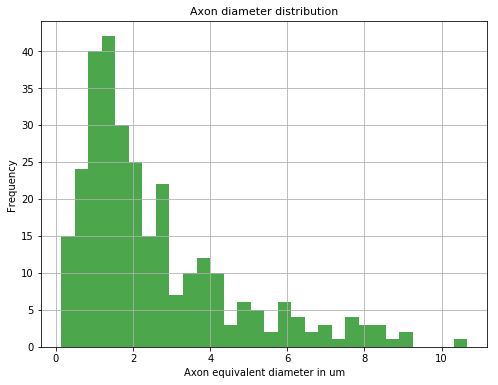

In [167]:
# Plot histogram of axon diameter distribution
plt.figure(figsize=(8,6))
n, bins, patches = plt.hist(axon_diam_list,30, facecolor='g', alpha=0.7)
plt.xlabel('Axon equivalent diameter in um',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Axon diameter distribution',fontsize=11)
plt.grid(True)

#### 4) Display boxplots of other axonal morphometrics (example with solidity and eccentricity)

In [168]:
# Get axon solidity distribution (measure of compactness of the axon)
axon_solidity_list = [d['solidity'] for d in stats_array]
# Get axon eccentricity distribution (measure of ellipticity/extent of the axon)
axon_eccentricity_list = [d['eccentricity'] for d in stats_array]

[Text(0,0,u'Solidity'), Text(0,0,u'Eccentricity')]

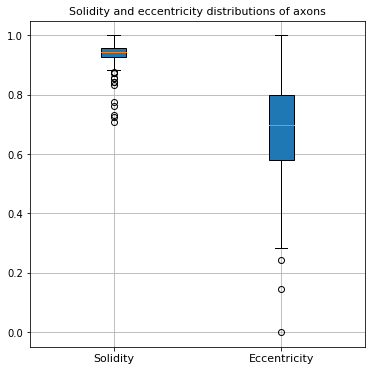

In [169]:
# Plot boxplots of solidity and eccentricity
plt.figure(figsize=(6,6))
data_to_plot = [axon_solidity_list,axon_eccentricity_list]
plt.boxplot(data_to_plot,patch_artist=True)
plt.title('Solidity and eccentricity distributions of axons',fontsize=11)
plt.grid(True)
frame1 = plt.gca()
frame1.set_xticklabels(['Solidity', 'Eccentricity'],fontsize=11)

#### 5) Display and save axon mask overlay labelled for axon diameter

#### 6) Compute aggregate axon/myelin morphometrics

In [172]:
# Compute aggregate metrics
aggregate_metrics = get_aggregate_morphometrics(pred_axon,pred_myelin)
print aggregate_metrics

{'mean_axon_diam': 2.5575044164131997, 'mean_myelin_thickness': 0.5939360324353604, 'mvf': 0.3438579081741404, 'mean_myelin_diam': 3.7453764812839205, 'axon_density_mm2': 36008.66257253812, 'avf': 0.30040214667696113, 'gratio': 0.6828430811143673}


#### 7) Save aggregate metrics

In [173]:
write_aggregate_morphometrics(path_folder,aggregate_metrics)

#### 8) 

2.572955000815824


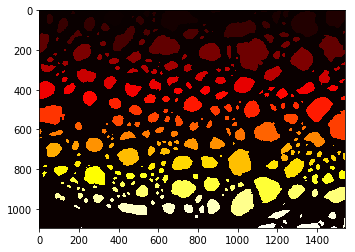

In [29]:
labels = measure.label(pred_axon)
axon_objects = regionprops(labels)



plt.imshow(labels,cmap='hot')

imageio.imwrite('aaa.png', labels)


In [171]:
labels(1150,600)

TypeError: 'numpy.ndarray' object is not callable

In [172]:
print np.min(labels)

0


In [23]:


axon_diam_list = [d['axon_diam'] for d in stats_array]

axon_iter = np.arange(np.size(axon_diam_list))


for pix_x in np.arange(np.shape(labels)[0]):
       for pix_y in np.arange(np.shape(labels)[1]):
            labels[pix_x,pix_y] = axon_diam_list[labels[pix_x,pix_y]]




IndexError: list index out of range

In [25]:
labels==2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
axon_iter = np.arange(np.size(axon_diam_list))

In [24]:
np.size(pred_axon)

1688936

#### Other useful code snippets

In [175]:
# Show metrics available for axons
print stats_array[0].keys()

['axon_diam', 'solidity', 'eccentricity', 'y0', 'x0', 'orientation']


In [176]:
# Get axon diameter value of axon object 0
print stats_array[0]['axon_diam']

1.69958776035


In [177]:
# Get solidity value of axon object 50
print stats_array[49]['solidity']

0.9677523379554982


In [179]:
# Display all stats for axon object 10
print stats_array[9]

{'axon_diam': 6.660677996480354, 'solidity': 0.9674829931972789, 'eccentricity': 0.4595592043543096, 'y0': 39.49430459850935, 'x0': 1491.883279426241, 'orientation': 0.2026448234414792}


In [180]:
# Get axon diameter value of all axons in list
axon_diam_list = [d['axon_diam'] for d in stats_array]

In [181]:
# Get number of axons in sample
print np.size(axon_diam_list)

298


In [182]:
# Get mean diameter
mean_diam = np.mean(axon_diam_list)
print mean_diam

2.5575044164131997


In [183]:
# Get max diameter
max_diam = np.max(axon_diam_list)
print max_diam

10.661720314980407
